In [33]:
!pip install pytorch-tabnet --quiet
!pip install wget --quiet

In [34]:
import torch
from torch.nn import Linear, BatchNorm1d, ReLU
import numpy as np
from pytorch_tabnet import sparsemax

#  Bloque TabNet Pretraining

In [35]:
class TabNetPretraining(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        pretraining_ratio=0.2,
        n_d=8,
        n_a=8,
        n_steps=3,
        gamma=1.3,
        cat_idxs=[],
        cat_dims=[],
        cat_emb_dim=1,
        n_independent=2,
        n_shared=2,
        epsilon=1e-15,
        virtual_batch_size=128,
        momentum=0.02,
        mask_type="sparsemax",
        n_shared_decoder=1,
        n_indep_decoder=1,
        group_attention_matrix=None,
    ):
        super(TabNetPretraining, self).__init__()

        self.cat_idxs = cat_idxs or []
        self.cat_dims = cat_dims or []
        self.cat_emb_dim = cat_emb_dim

        self.input_dim = input_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.mask_type = mask_type
        self.pretraining_ratio = pretraining_ratio
        self.n_shared_decoder = n_shared_decoder
        self.n_indep_decoder = n_indep_decoder

        if self.n_steps <= 0:
            raise ValueError("n_steps should be a positive integer.")
        if self.n_independent == 0 and self.n_shared == 0:
            raise ValueError("n_shared and n_independent can't be both zero.")

        self.virtual_batch_size = virtual_batch_size
        self.embedder =  tab_network.EmbeddingGenerator(input_dim,
                                           cat_dims,
                                           cat_idxs,
                                           cat_emb_dim,
                                           group_attention_matrix)
        self.post_embed_dim = self.embedder.post_embed_dim

        self.masker =  tab_network.RandomObfuscator(self.pretraining_ratio,
                                       group_matrix=self.embedder.embedding_group_matrix)
        self.encoder =  tab_network.TabNetEncoder(
            input_dim=self.post_embed_dim,
            output_dim=self.post_embed_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            mask_type=mask_type,
            group_attention_matrix=self.embedder.embedding_group_matrix,
        )
        self.decoder =  tab_network.TabNetDecoder(
            self.post_embed_dim,
            n_d=n_d,
            n_steps=n_steps,
            n_independent=self.n_indep_decoder,
            n_shared=self.n_shared_decoder,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
        )

    def forward(self, x):
        """
        Returns: res, embedded_x, obf_vars
            res : output of reconstruction
            embedded_x : embedded input
            obf_vars : which variable where obfuscated
        """
        embedded_x = self.embedder(x)
        if self.training:
            masked_x, obfuscated_groups, obfuscated_vars = self.masker(embedded_x)
            # set prior of encoder with obfuscated groups
            prior = 1 - obfuscated_groups
            steps_out, _ = self.encoder(masked_x, prior=prior)
            res = self.decoder(steps_out)
            return res, embedded_x, obfuscated_vars, torch.sum(torch.stack(steps_out, dim=0), dim=0)
        else:
            steps_out, _ = self.encoder(embedded_x)
            res = self.decoder(steps_out)
            #Modificado para sacar el encoder
            return res, embedded_x, torch.ones(embedded_x.shape).to(x.device),  torch.sum(torch.stack(steps_out, dim=0), dim=0)


    def forward_masks(self, x):
        embedded_x = self.embedder(x)
        return self.encoder.forward_masks(embedded_x)





#  Unsupervised TabNetPretrainer (Modificado)

In [36]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from pytorch_tabnet import tab_network
from pytorch_tabnet.utils import (
    create_explain_matrix,
    filter_weights,
    SparsePredictDataset,
    PredictDataset,
    check_input,
    create_group_matrix,
)
from torch.nn.utils import clip_grad_norm_
from pytorch_tabnet.pretraining_utils import (
    create_dataloaders,
    validate_eval_set,
)
from pytorch_tabnet.metrics import (
    UnsupMetricContainer,
    check_metrics,
    UnsupervisedLoss,
)
from pytorch_tabnet.abstract_model import TabModel
import scipy


class TabNetPretrainer(TabModel):
    def __post_init__(self):
        super(TabNetPretrainer, self).__post_init__()
        self._task = 'unsupervised'
        self._default_loss = UnsupervisedLoss
        self._default_metric = 'unsup_loss_numpy'

    def prepare_target(self, y):
        return y

    def compute_loss(self, output, embedded_x, obf_vars):
        return self.loss_fn(output, embedded_x, obf_vars)

    def update_fit_params(
        self,
        weights,
    ):
        self.updated_weights = weights
        filter_weights(self.updated_weights)
        self.preds_mapper = None

    def fit(
        self,
        X_train,
        eval_set=None,
        eval_name=None,
        loss_fn=None,
        pretraining_ratio=0.5,
        weights=0,
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=True,
        callbacks=None,
        pin_memory=True,
        warm_start=False
    ):
        """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.

        Parameters
        ----------
        X_train : np.ndarray
            Train set to reconstruct in self supervision
        eval_set : list of np.array
            List of evaluation set
            The last one is used for early stopping
        eval_name : list of str
            List of eval set names.
        eval_metric : list of str
            List of evaluation metrics.
            The last metric is used for early stopping.
        loss_fn : callable or None
            a PyTorch loss function
            should be left to None for self supervised and non experts
        pretraining_ratio : float
            Between 0 and 1, percentage of feature to mask for reconstruction
        weights : np.array
            Sampling weights for each example.
        max_epochs : int
            Maximum number of epochs during training
        patience : int
            Number of consecutive non improving epoch before early stopping
        batch_size : int
            Training batch size
        virtual_batch_size : int
            Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
        num_workers : int
            Number of workers used in torch.utils.data.DataLoader
        drop_last : bool
            Whether to drop last batch during training
        callbacks : list of callback function
            List of custom callbacks
        pin_memory: bool
            Whether to set pin_memory to True or False during training
        """
        # update model name

        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.num_workers = num_workers
        self.drop_last = drop_last
        self.input_dim = X_train.shape[1]
        self._stop_training = False
        self.pin_memory = pin_memory and (self.device.type != "cpu")
        self.pretraining_ratio = pretraining_ratio
        eval_set = eval_set if eval_set else []

        if loss_fn is None:
            self.loss_fn = self._default_loss
        else:
            self.loss_fn = loss_fn

        check_input(X_train)

        self.update_fit_params(
            weights,
        )

        # Validate and reformat eval set depending on training data
        eval_names = validate_eval_set(eval_set, eval_name, X_train)
        train_dataloader, valid_dataloaders = self._construct_loaders(
            X_train, eval_set
        )

        if not hasattr(self, "network") or not warm_start:
            # model has never been fitted before of warm_start is False
            self._set_network()

        self._update_network_params()
        self._set_metrics(eval_names)
        self._set_optimizer()
        self._set_callbacks(callbacks)

        # Call method on_train_begin for all callbacks
        self._callback_container.on_train_begin()

        # Training loop over epochs
        for epoch_idx in range(self.max_epochs):

            # Call method on_epoch_begin for all callbacks
            self._callback_container.on_epoch_begin(epoch_idx)

            self._train_epoch(train_dataloader)

            # Apply predict epoch to all eval sets
            for eval_name, valid_dataloader in zip(eval_names, valid_dataloaders):
                self._predict_epoch(eval_name, valid_dataloader)

            # Call method on_epoch_end for all callbacks
            self._callback_container.on_epoch_end(
                epoch_idx, logs=self.history.epoch_metrics
            )

            if self._stop_training:
                break

        # Call method on_train_end for all callbacks
        self._callback_container.on_train_end()
        self.network.eval()

    def _set_network(self):
        """Setup the network and explain matrix."""
        if not hasattr(self, 'pretraining_ratio'):
            self.pretraining_ratio = 0.5
        torch.manual_seed(self.seed)

        self.group_matrix = create_group_matrix(self.grouped_features, self.input_dim)

        self.network = TabNetPretraining(
            self.input_dim,
            pretraining_ratio=self.pretraining_ratio,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            n_shared_decoder=self.n_shared_decoder,
            n_indep_decoder=self.n_indep_decoder,
            epsilon=self.epsilon,
            virtual_batch_size=self.virtual_batch_size,
            momentum=self.momentum,
            mask_type=self.mask_type,
            group_attention_matrix=self.group_matrix.to(self.device),
        ).to(self.device)

        self.reducing_matrix = create_explain_matrix(
            self.network.input_dim,
            self.network.cat_emb_dim,
            self.network.cat_idxs,
            self.network.post_embed_dim,
        )

    def _update_network_params(self):
        self.network.virtual_batch_size = self.virtual_batch_size
        self.network.pretraining_ratio = self.pretraining_ratio

    def _set_metrics(self, eval_names):
        """Set attributes relative to the metrics.

        Parameters
        ----------
        metrics : list of str
            List of eval metric names.
        eval_names : list of str
            List of eval set names.

        """
        metrics = [self._default_metric]

        metrics = check_metrics(metrics)
        # Set metric container for each sets
        self._metric_container_dict = {}
        for name in eval_names:
            self._metric_container_dict.update(
                {name: UnsupMetricContainer(metrics, prefix=f"{name}_")}
            )

        self._metrics = []
        self._metrics_names = []
        for _, metric_container in self._metric_container_dict.items():
            self._metrics.extend(metric_container.metrics)
            self._metrics_names.extend(metric_container.names)

        # Early stopping metric is the last eval metric
        self.early_stopping_metric = (
            self._metrics_names[-1] if len(self._metrics_names) > 0 else None
        )

    def _construct_loaders(self, X_train, eval_set):
        """Generate dataloaders for unsupervised train and eval set.

        Parameters
        ----------
        X_train : np.array
            Train set.
        eval_set : list of tuple
            List of eval tuple set (X, y).

        Returns
        -------
        train_dataloader : `torch.utils.data.Dataloader`
            Training dataloader.
        valid_dataloaders : list of `torch.utils.data.Dataloader`
            List of validation dataloaders.

        """
        train_dataloader, valid_dataloaders = create_dataloaders(
            X_train,
            eval_set,
            self.updated_weights,
            self.batch_size,
            self.num_workers,
            self.drop_last,
            self.pin_memory,
        )
        return train_dataloader, valid_dataloaders

    def _train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network

        Parameters
        ----------
        train_loader : a :class: `torch.utils.data.Dataloader`
            DataLoader with train set
        """
        self.network.train()

        for batch_idx, X in enumerate(train_loader):
            self._callback_container.on_batch_begin(batch_idx)

            batch_logs = self._train_batch(X)

            self._callback_container.on_batch_end(batch_idx, batch_logs)

        epoch_logs = {"lr": self._optimizer.param_groups[-1]["lr"]}
        self.history.epoch_metrics.update(epoch_logs)

        return

    def _train_batch(self, X):
        """
        Trains one batch of data

        Parameters
        ----------
        X : torch.Tensor
            Train matrix

        Returns
        -------
        batch_outs : dict
            Dictionnary with "y": target and "score": prediction scores.
        batch_logs : dict
            Dictionnary with "batch_size" and "loss".
        """
        batch_logs = {"batch_size": X.shape[0]}

        X = X.to(self.device).float()

        for param in self.network.parameters():
            param.grad = None
        #Modificado
        #steps_out: salida del enconder
        output, embedded_x, obf_vars, steps_out  = self.network(X)
        loss = self.compute_loss(output, embedded_x, obf_vars)

        # Perform backward pass and optimization
        loss.backward()
        if self.clip_value:
            clip_grad_norm_(self.network.parameters(), self.clip_value)
        self._optimizer.step()

        batch_logs["loss"] = loss.cpu().detach().numpy().item()

        return batch_logs

    def _predict_epoch(self, name, loader):
        """
        Predict an epoch and update metrics.

        Parameters
        ----------
        name : str
            Name of the validation set
        loader : torch.utils.data.Dataloader
                DataLoader with validation set
        """
        # Setting network on evaluation mode
        self.network.eval()

        list_output = []
        list_embedded_x = []
        list_obfuscation = []
        list_steps_out = []
        # Main loop
        #Modificado
        for batch_idx, X in enumerate(loader):
            output, embedded_x, obf_vars, steps_out = self._predict_batch(X)
            list_output.append(output.cpu().detach().numpy())
            list_embedded_x.append(embedded_x.cpu().detach().numpy())
            list_obfuscation.append(obf_vars.cpu().detach().numpy())
            list_steps_out.append(steps_out.cpu().detach().numpy())
        #Modificado
        output, embedded_x, obf_vars, steps_out = self.stack_batches(list_output,
                                                          list_embedded_x,
                                                          list_obfuscation, list_steps_out)

        metrics_logs = self._metric_container_dict[name](output, embedded_x, obf_vars)
        self.network.train()
        self.history.epoch_metrics.update(metrics_logs)
        return

    def _predict_batch(self, X):
        """
        Predict one batch of data.

        Parameters
        ----------
        X : torch.Tensor
            Owned products

        Returns
        -------
        np.array
            model scores
        """
        X = X.to(self.device).float()
        return self.network(X)
    #Modificado
    def stack_batches(self, list_output, list_embedded_x, list_obfuscation, list_steps_out):
        output = np.vstack(list_output)
        embedded_x = np.vstack(list_embedded_x)
        obf_vars = np.vstack(list_obfuscation)
        steps_out_encoder = np.vstack(list_steps_out)
        return output, embedded_x, obf_vars, steps_out_encoder


#Modificado
    def predict(self, X):
        """
        Make predictions on a batch (valid)

        Parameters
        ----------
        X : a :tensor: `torch.Tensor` or matrix: `scipy.sparse.csr_matrix`
            Input data

        Returns
        -------
        predictions : np.array
            Predictions of the regression problem
        """
        self.network.eval()

        if scipy.sparse.issparse(X):
            dataloader = DataLoader(
                SparsePredictDataset(X),
                batch_size=self.batch_size,
                shuffle=False,
            )
        else:
            dataloader = DataLoader(
                PredictDataset(X),
                batch_size=self.batch_size,
                shuffle=False,
            )

        results = []
        embedded_res = []
        encoded_res = []

        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()
            output, embeded_x, _, steps_out = self.network(data)
            predictions = output.cpu().detach().numpy()
            encoded_o = steps_out.cpu().detach().numpy()
            results.append(predictions)
            encoded_res.append(encoded_o)
            embedded_res.append(embeded_x.cpu().detach().numpy())
        res_output = np.vstack(results)
        encoded_output = np.vstack(encoded_res)
        embedded_inputs = np.vstack(embedded_res)
        return res_output, embedded_inputs, encoded_output

In [37]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
#import wget
from pathlib import Path

In [38]:
import pandas as pd

# Load data and split

In [39]:
#ojo etiquetas
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
  # Clone the repository if it doesn't exist
  !git clone -l -s $repo_url


!unzip -o /content/Datasets_biplot/PhenotypingData.zip


csv_path = '/content/PhenotypingData.csv' #database directory on collaborative disk according to prevously uploaded file

data = pd.read_csv(csv_path, sep = ';') #read csv file


Archive:  /content/Datasets_biplot/PhenotypingData.zip
  inflating: PhenotypingData.csv     
  inflating: __MACOSX/._PhenotypingData.csv  
  inflating: Climate.txt             
  inflating: __MACOSX/._Climate.txt  
  inflating: All_TDRdata.txt         
  inflating: __MACOSX/._All_TDRdata.txt  


In [40]:
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
  # Clone the repository if it doesn't exist
  !git clone -l -s $repo_url

!unzip -o /content/Datasets_biplot/PhenotypingData.zip


csv_path = '/content/PhenotypingData.csv' #database directory on collaborative disk according to prevously uploaded file
data = pd.read_csv(csv_path, sep = ';') #read csv file

Archive:  /content/Datasets_biplot/PhenotypingData.zip
  inflating: PhenotypingData.csv     
  inflating: __MACOSX/._PhenotypingData.csv  
  inflating: Climate.txt             
  inflating: __MACOSX/._Climate.txt  
  inflating: All_TDRdata.txt         
  inflating: __MACOSX/._All_TDRdata.txt  


In [41]:
#data.info()
data.rename(columns={'FamKloon':'Famclone', 'Soort': 'Variety', 'GR_Rat':'G/R', 'Hue_val': 'H',
       'S_val' : 'S', 'V_val' : 'V', 'L_val' : 'L', 'a_val' : 'a*', 'b_val':'b*', 'I_val':'I' ,
       'G_R': 'G-R', 'G_B' : 'G-B', 'u_val': 'u*', 'v_val': 'v*'}, inplace=True)
data.drop(columns= ['Famclone', 'Code'	], inplace=True)#

In [42]:
# Suponiendo que Data_sel es un DataFrame de pandas
mapping = {

    130716: 1,
    130828: 2,
    130906: 3
}

data['Date'].replace(mapping, inplace=True)

<ipython-input-42-45dc4bb94db6>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Date'].replace(mapping, inplace=True)


In [43]:
# data['Variety'].replace(['Fa', 'Lp2n', 'Lp4n'],
#                         [1, 2, 3], inplace=True)


data = data.dropna().reset_index(drop=True)

data.loc[:,'CWSI'] += 0.0005 #esta columna tiene datos en ceros

In [44]:
data.drop(columns= ['Rkap'], inplace=True) # Remove 'Rkap' column inplace
data = data.reset_index(drop=True) # Reset index and reassign to data


In [45]:

#target = data ['Score']
date= data['Date']


Xdata = data.iloc[:, 0:41].copy() #.iloc[:, 3:40].copy()
ydata = np.uint8(data['Score'])


In [46]:
Xdata

,Date,Variety,dT,CWSI,R,G,B,RCC,GCC,BCC,...,CIVE,VEG,ExR,WI,ExGR,u*,v*,uv,NDLuv,Score
0,1,Lp4n,5.8,0.687914,23.302905,34.327801,17.257261,0.311170,0.458389,0.230441,...,5.464834,1.628065,-0.022750,-1.548363,0.397917,-3.834615,7.653823,-29.349465,0.774255,9.0
1,1,Fa,2.2,0.237970,20.627660,31.585106,14.968085,0.307047,0.470150,0.222803,...,5.820032,1.703781,-0.040285,-1.516505,0.450736,-3.599065,6.996044,-25.179219,0.793277,9.0
2,1,Fa,1.8,0.187977,19.860759,31.430380,13.987342,0.304247,0.481481,0.214272,...,5.240557,1.778511,-0.055536,-1.507659,0.499981,-3.773663,7.234640,-27.301090,0.795060,9.0
3,1,Fa,2.1,0.225472,20.373684,32.968421,15.894737,0.294261,0.476169,0.229571,...,4.846089,1.757646,-0.064204,-1.355621,0.492710,-4.231430,7.330937,-31.020344,0.832873,9.0
4,1,Lp2n,2.5,0.275466,20.573171,32.908537,14.432927,0.302927,0.484557,0.212516,...,4.424024,1.799996,-0.060460,-1.497776,0.514132,-4.144362,7.860748,-32.577786,0.791129,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,3,Fa,3.9,0.000500,28.092199,41.794326,19.007194,0.316020,0.470161,0.213819,...,1.672628,1.694459,-0.027733,-1.663036,0.438214,-5.292481,11.110935,-58.804415,0.723132,8.0
3170,3,Lp2n,10.1,0.526589,42.896296,47.437037,22.822222,0.379091,0.419220,0.201689,...,4.698793,1.364459,0.111508,-5.420881,0.146151,-1.392262,13.356219,-18.595358,0.303809,6.0
3171,3,Lp4n,4.1,0.009124,32.722222,44.092593,20.648148,0.335740,0.452404,0.211856,...,2.321463,1.570761,0.017633,-2.061889,0.339578,-4.484252,11.900111,-53.363100,0.630941,7.0
3172,3,Fa,3.2,0.000500,28.609589,43.445205,20.198630,0.310120,0.470933,0.218947,...,0.905075,1.705204,-0.036766,-1.566944,0.449566,-5.826698,11.521824,-67.134187,0.744114,9.0


In [47]:
train = Xdata #pd.read_csv(out)

In [48]:

target = 'Score'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))
    #train["Set"] = np.random.choice(["train",  "test"], p =[.7, .3], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
#valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [49]:
train_indices.shape

(2505,)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [50]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Variety 3
Set 3


# Define categorical features for categorical embeddings

In [51]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Training

In [52]:
from sklearn.model_selection import train_test_split


#E = X.copy()
#E_train, E_valid, y_train, y_valid = train_test_split( E, y.to_numpy(), train_size=2500, test_size=500)
X_train, X_test, y_train, y_test = train_test_split( train[features].values, train[target].values.reshape(-1, 1), train_size=2650, test_size=500)
X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, test_size=150)

In [53]:
print('train shape:',X_train.shape , 'test shape:',  X_test.shape, 'valid shape:',  X_valid.shape)

train shape: (2500, 39) test shape: (500, 39) valid shape: (150, 39)


In [54]:
max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

In [55]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    gamma = 1.6,
    n_d=10,
    n_a=10,
    n_steps=5,
    lambda_sparse=0.01,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",  #'entmax',
    n_shared_decoder=2, # nb shared glu for decoding
    n_indep_decoder=2, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [56]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=500, virtual_batch_size=125,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)


epoch 0  | loss: 837.86906| val_0_unsup_loss_numpy: 11846.126953125|  0:00:00s
epoch 5  | loss: 19.40006| val_0_unsup_loss_numpy: 22.424280166625977|  0:00:04s
epoch 10 | loss: 3.56005 | val_0_unsup_loss_numpy: 2.325550079345703|  0:00:11s
epoch 15 | loss: 2.14886 | val_0_unsup_loss_numpy: 1.8682299852371216|  0:00:16s
epoch 20 | loss: 1.35181 | val_0_unsup_loss_numpy: 1.2996000051498413|  0:00:21s
epoch 25 | loss: 1.01208 | val_0_unsup_loss_numpy: 1.312749981880188|  0:00:25s
epoch 30 | loss: 0.81833 | val_0_unsup_loss_numpy: 0.925570011138916|  0:00:27s
epoch 35 | loss: 0.68548 | val_0_unsup_loss_numpy: 0.7928100228309631|  0:00:29s
epoch 40 | loss: 0.59401 | val_0_unsup_loss_numpy: 0.6319699883460999|  0:00:32s

Early stopping occurred at epoch 43 with best_epoch = 38 and best_val_0_unsup_loss_numpy = 0.5927199721336365


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


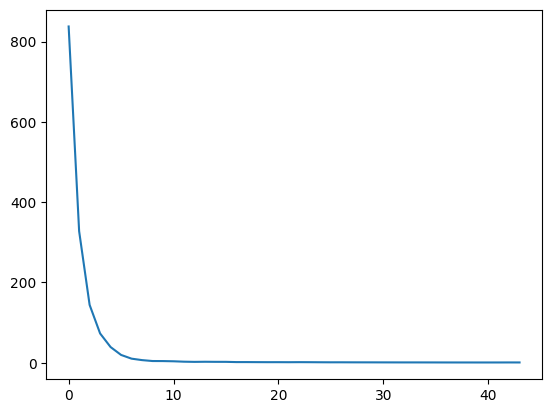

In [57]:
import matplotlib.pyplot as plt
# plot losses
plt.plot(unsupervised_model.history['loss'])


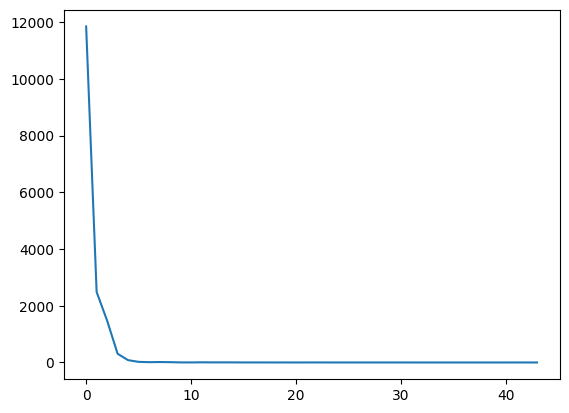

In [58]:
# plot Val loss
plt.plot(unsupervised_model.history['val_0_unsup_loss_numpy'])
#plt.plot(clf.history['valid_mse'])

In [59]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X , encoder = unsupervised_model.predict(X_test)
assert(reconstructed_X.shape==embedded_X.shape)

In [60]:
encoder.shape


(500, 10)

#Salida encoder con T-sne

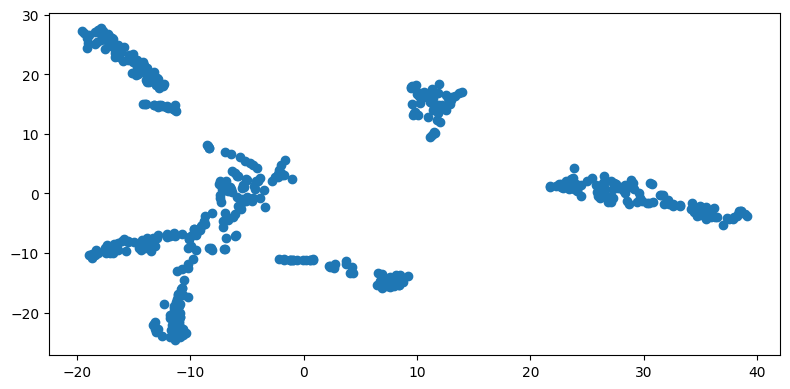

In [61]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2).fit_transform(encoder)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))  # (1 fila, 2 columnas)
axs.scatter(x_embedded[:,0], x_embedded[:,1])
plt.tight_layout()
plt.show()


# Mascaras

In [62]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_test)

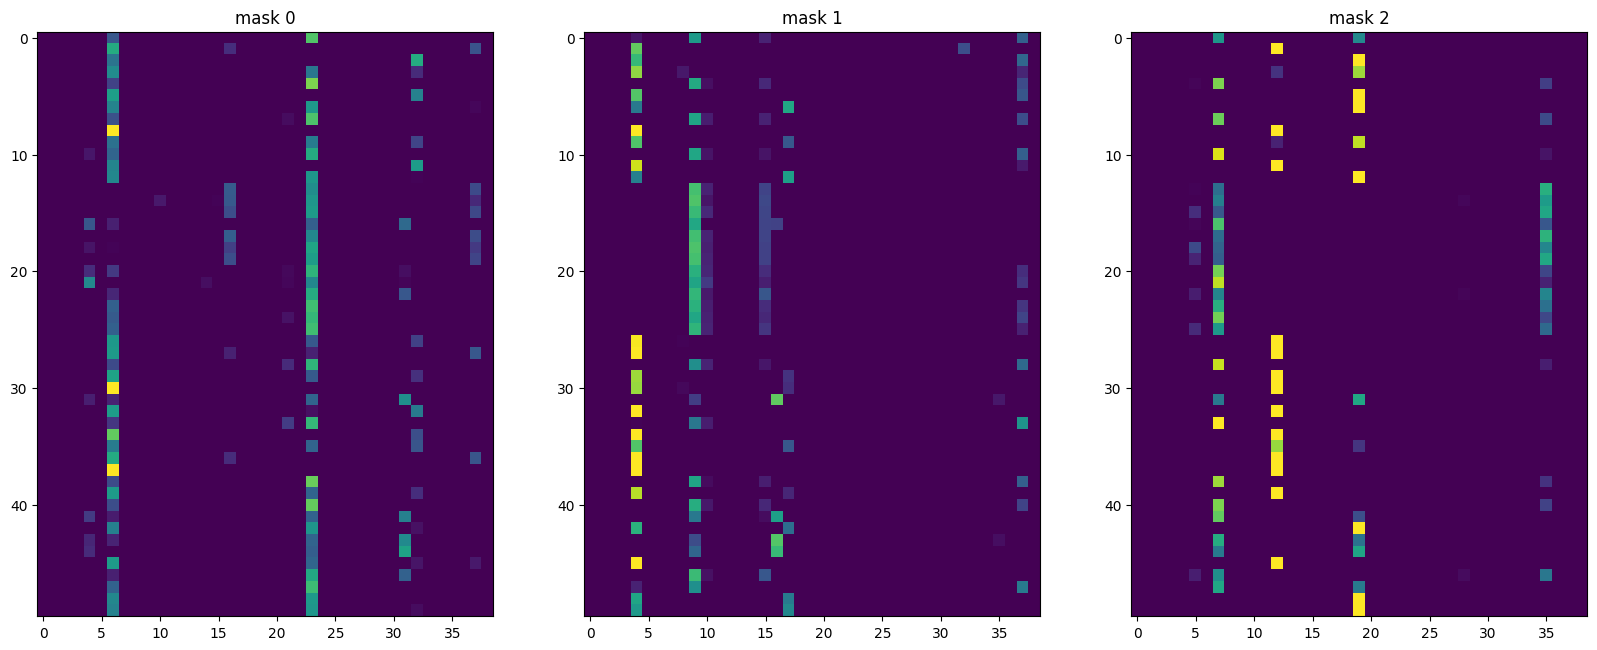

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


# Explain Matrix

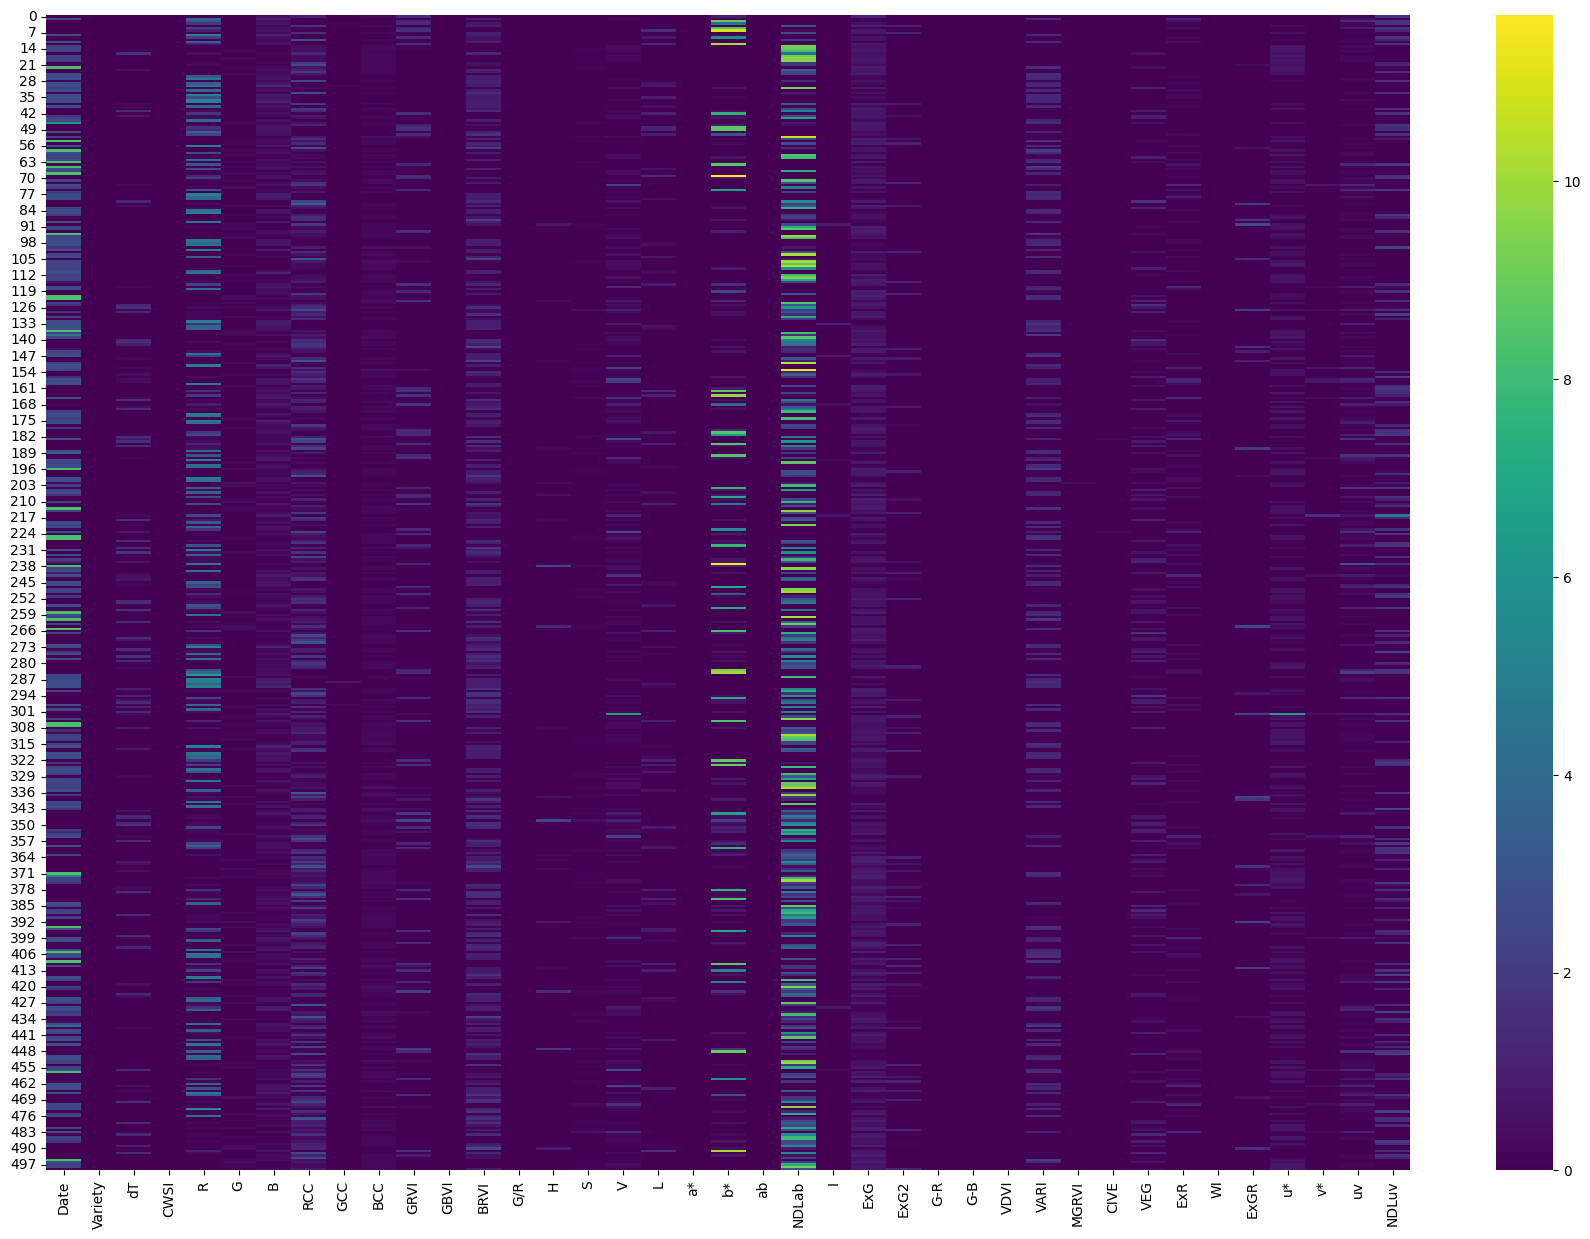

In [64]:
import seaborn as sns

# Set the size of the figure
plt.figure(figsize=(22, 15))  # Width, Height in inches

# Create a heatmap
sns.heatmap(pd.DataFrame(unsupervised_explain_matrix, columns=features),cmap="viridis")

# Show the plot
plt.show()